# Simulation on the fully synthetic classification and regression datasets

In [1]:
import numpy as np
import pandas as pd
from distEst_lib import MultivarContiDistributionEstimator
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import mechanismlearn as ml
syn_data_dir = r"../test_data/simu_data/synthetic_data/"

plt.rcParams['font.family'] = 'Calibri'
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["axes.titlesize"] = 16

## Classification

#### Read datasets

In [2]:
testcase_dir = r"frontdoor_discY_contZ_contX_discU/"
X_train_conf = pd.read_csv(syn_data_dir + testcase_dir + "X_train_conf.csv")
Y_train_conf = pd.read_csv(syn_data_dir + testcase_dir + "Y_train_conf.csv")
Z_train_conf = pd.read_csv(syn_data_dir + testcase_dir + "Z_train_conf.csv")
X_train_conf = np.array(X_train_conf)
Y_train_conf = np.array(Y_train_conf).reshape(-1,1)
Z_train_conf = np.array(Z_train_conf)

X_test_unconf = pd.read_csv(syn_data_dir + testcase_dir + "X_test_unconf.csv")
Y_test_unconf = pd.read_csv(syn_data_dir + testcase_dir + "Y_test_unconf.csv")
X_test_unconf = np.array(X_test_unconf)
Y_test_unconf = np.array(Y_test_unconf).reshape(-1,1)

X_test_conf = pd.read_csv(syn_data_dir + testcase_dir + "X_test_conf.csv")
Y_test_conf = pd.read_csv(syn_data_dir + testcase_dir + "Y_test_conf.csv")
X_test_conf = np.array(X_test_conf)
Y_test_conf = np.array(Y_test_conf).reshape(-1,1)

#### Train a deconfounded SVM classifier using mechanism learning

In [3]:
clf_deconf, deconf_data = ml.mechanism_classifier(cause_data = {"Y": Y_train_conf}, 
                                                  mediator_data = {"Z": Z_train_conf},
                                                  effect_data = {"X": X_train_conf}, 
                                                  n_bins = [0,20],
                                                  ml_model = svm.SVC(kernel = 'linear', C=5), 
                                                  rebalance = False, 
                                                  n_samples = None, 
                                                  cb_mode = "fast",
                                                  output_data = True)

#### Train a confounded SVM classifier

In [4]:
clf_conf = svm.SVC(kernel = 'linear', C=5)
clf_conf = clf_conf.fit(X_train_conf, Y_train_conf.reshape(-1))

#### Compare thier decision boundaries

In [5]:
weight = clf_deconf.coef_[0]
bias = clf_deconf.intercept_[0]
k = -weight[0] / weight[1]
b = -bias / weight[1]
x_ = np.linspace(-4, 4, 100)
decison_boundary_deconf = k * x_ + b

weight = clf_conf.coef_[0]
bias = clf_conf.intercept_[0]
k = -weight[0] / weight[1]
b = -bias / weight[1]
x_ = np.linspace(-4, 4, 100)
decison_boundary_conf = k * x_ + b

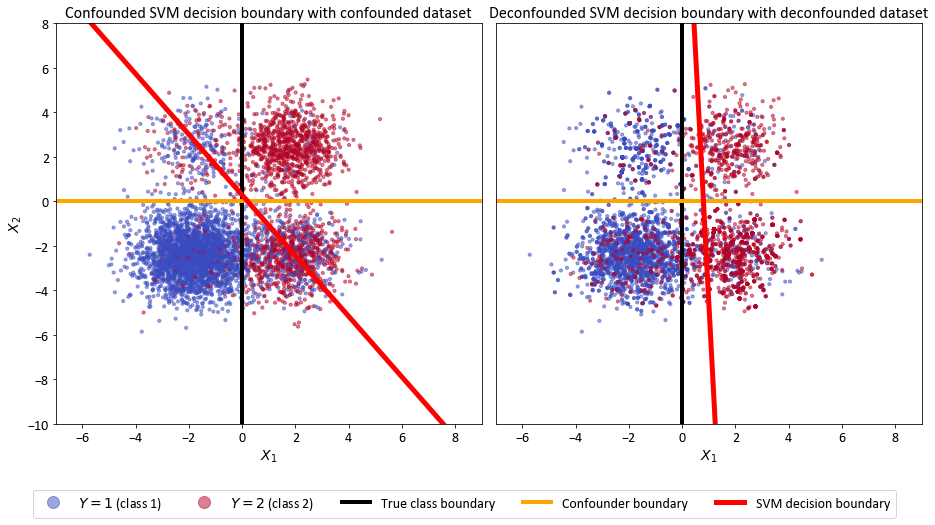

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(13, 7))

handles = []
labels = [r'$Y=1$ (class 1)', r'$Y=2$ (class 2)',
          'True class boundary', 'Confounder boundary', 'SVM decision boundary']

# Plot confounded SVM on confounded dataset
ax = axs[0]
scatter = ax.scatter(x=X_train_conf[:, 0], y=X_train_conf[:, 1], c=Y_train_conf, s=10,
                     cmap='coolwarm', alpha=0.5)
handles_scatter, labels_scatter = scatter.legend_elements(prop="colors")
handles += handles_scatter
ax.set_xlim(-7, 9)
ax.set_ylim(-10, 8)
x_ = np.linspace(-8, 8, 100)
true_b = ax.plot([0, 0], [-10, 10], linewidth=4, color="black")
confounder = ax.plot([-10, 10], [0, 0], linewidth=4, color="orange")
clf_b_conf = ax.plot(x_, decison_boundary_conf, linewidth=5, color="red")

handles += [true_b[0], confounder[0], clf_b_conf[0]]
ax.set_title("Confounded SVM decision boundary with confounded dataset")
ax.set_xlabel(r"$X_1$")
ax.set_ylabel(r"$X_2$")

# Plot deconfounded SVM on deconfounded dataset
ax = axs[1]
scatter = ax.scatter(x=deconf_data[0][:, 0], y=deconf_data[0][:, 1], c=deconf_data[1], s=10,
                     cmap='coolwarm', alpha=0.5)
ax.set_xlim(-7, 9)
ax.set_ylim(-10, 8)
x_ = np.linspace(-8, 8, 100)
true_b = ax.plot([0, 0], [-10, 10], linewidth=4, color="black")
confounder = ax.plot([-10, 10], [0, 0], linewidth=4, color="orange")
clf_b_deconf = ax.plot(x_, decison_boundary_deconf, linewidth=5, color="red")

ax.set_title("Deconfounded SVM decision boundary with deconfounded dataset")
ax.set_xlabel(r"$X_1$")
ax.set_yticks([])
fig.legend(handles=handles,
           labels=labels,
           loc='lower center',
           bbox_to_anchor=(0.5, -0.05),
           ncol=5,
           markerscale=2)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

#### Compare thier performance on different test datasets

In [7]:
print("Test on the non-confounded test set:")
y_pred_deconf_unconf = clf_deconf.predict(X_test_unconf)
print("Report of de-confonded model:")
print(classification_report(Y_test_unconf, y_pred_deconf_unconf))

print("-"*20)
y_pred_conf_unconf = clf_conf.predict(X_test_unconf)
print("Report of confonded model:")
print(classification_report(Y_test_unconf, y_pred_conf_unconf))

print("*"*30)
print("Test on the confounded test set:")
y_pred_deconf_conf = clf_deconf.predict(X_test_conf)
print("Report of de-confonded model:")
print(classification_report(Y_test_conf, y_pred_deconf_conf))

print("-"*20)
y_pred_conf_conf = clf_conf.predict(X_test_conf)
print("Report of confonded model:")
print(classification_report(Y_test_conf, y_pred_conf_conf))

Test on the non-confounded test set:
Report of de-confonded model:
              precision    recall  f1-score   support

           1       0.72      0.86      0.79       362
           2       0.91      0.81      0.86       638

    accuracy                           0.83      1000
   macro avg       0.82      0.84      0.82      1000
weighted avg       0.84      0.83      0.83      1000

--------------------
Report of confonded model:
              precision    recall  f1-score   support

           1       0.65      0.86      0.74       362
           2       0.90      0.74      0.81       638

    accuracy                           0.78      1000
   macro avg       0.78      0.80      0.78      1000
weighted avg       0.81      0.78      0.79      1000

******************************
Test on the confounded test set:
Report of de-confonded model:
              precision    recall  f1-score   support

           1       0.89      0.88      0.88       632
           2       0.79     

## Regerssion

#### Read datasets

In [8]:
testcase_dir = r"frontdoor_contY_contZ_contX_contU/"
X_train_conf = pd.read_csv(syn_data_dir + testcase_dir + "X_train_conf.csv")
Y_train_conf = pd.read_csv(syn_data_dir + testcase_dir + "Y_train_conf.csv")
U_train_conf = pd.read_csv(syn_data_dir + testcase_dir + "U_train_conf.csv")
Z_train_conf = pd.read_csv(syn_data_dir + testcase_dir + "Z_train_conf.csv")
X_train_conf = np.array(X_train_conf).reshape(-1,1)
Y_train_conf = np.array(Y_train_conf).reshape(-1,1)
U_train_conf = np.array(U_train_conf).reshape(-1,1)
Z_train_conf = np.array(Z_train_conf).reshape(-1,1)

X_test_conf = pd.read_csv(syn_data_dir + testcase_dir + "X_test_conf.csv")
Y_test_conf = pd.read_csv(syn_data_dir + testcase_dir + "Y_test_conf.csv")
X_test_conf = np.array(X_test_conf).reshape(-1,1)
Y_test_conf = np.array(Y_test_conf).reshape(-1,1)

X_test_unconf = pd.read_csv(syn_data_dir + testcase_dir + "X_test_unconf.csv")
Y_test_unconf = pd.read_csv(syn_data_dir + testcase_dir + "Y_test_unconf.csv")
X_test_unconf = np.array(X_test_unconf).reshape(-1,1)
Y_test_unconf = np.array(Y_test_unconf).reshape(-1,1)

#### Estimate distributions for front-door causal bootstrapping explicitly

In [9]:
joint_yz_data = np.concatenate((Y_train_conf, Z_train_conf), axis = 1)
dist_estimator_yz = MultivarContiDistributionEstimator(data_fit=joint_yz_data)
pdf_yz, pyz = dist_estimator_yz.fit_multinorm()
dist_estimator_y = MultivarContiDistributionEstimator(data_fit=Y_train_conf)
pdf_y, py = dist_estimator_y.fit_multinorm()

dist_map = {"Y,Z": lambda Y, Z: pdf_yz([Y,Z]),
            "Y',Z": lambda Y_prime, Z: pdf_yz([Y_prime,Z]),
            "Y": lambda Y: pdf_y(Y),
            "Y'": lambda Y_prime: pdf_y(Y_prime)}

#### Prepare inputs for mechanism learning

In [10]:
N = X_train_conf.shape[0]
intv_intval_num = 50
Y_interv_values = np.linspace(np.mean(Y_train_conf) - 1.2*(np.max(Y_train_conf)- np.min(Y_train_conf)), 
                              np.mean(Y_train_conf) + 1.2*(np.max(Y_train_conf)- np.min(Y_train_conf)), 
                              intv_intval_num+1)
n_samples = [int(N/intv_intval_num)]*intv_intval_num

#### Train a deconfounded linear regressor with mechanism learning

In [11]:
reg_lr_deconf = LinearRegression()
reg_lr_deconf, deconf_data = ml.mechanism_regressor(cause_data = {"Y": Y_train_conf}, 
                                                    mediator_data = {"Z": Z_train_conf},
                                                    effect_data = {"X": X_train_conf}, 
                                                    ml_model = reg_lr_deconf,
                                                    intv_value = Y_interv_values, 
                                                    n_samples = n_samples, 
                                                    dist_map = dist_map, 
                                                    cb_mode = "fast",
                                                    output_data = True)

#### Train a confounded linear regressor

In [12]:
reg_lr_conf = LinearRegression()
reg_lr_conf = reg_lr_conf.fit(X_train_conf, Y_train_conf.reshape(-1))

#### Compare their regression lines

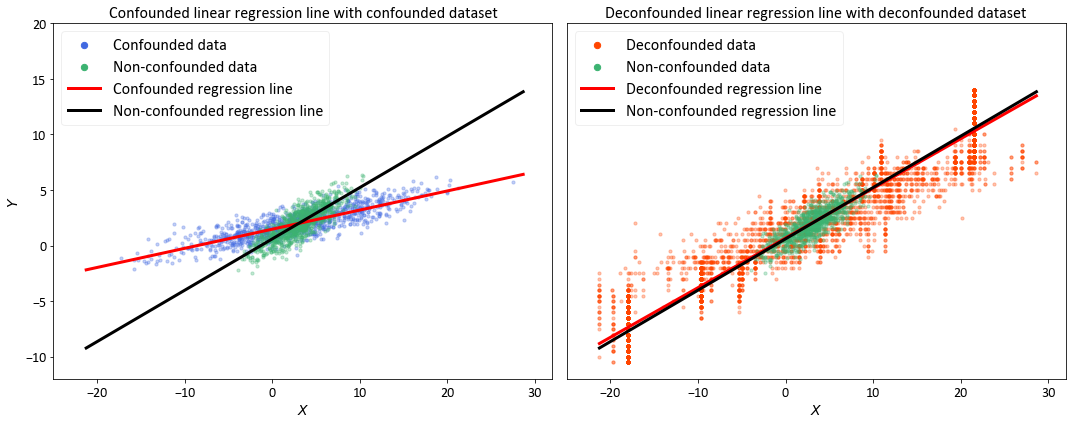

In [13]:
x_grid = np.linspace(np.min([np.min(X_train_conf), np.min(X_test_unconf)]),np.max([np.max(X_train_conf), np.max(X_test_unconf)]), num=1000)
regLine_conf = reg_lr_conf.predict(x_grid.reshape(-1,1))
regLine_deconf = reg_lr_deconf.predict(x_grid.reshape(-1,1))
# Train a ground truth linear regression model on the non-confounded test set
reg_lr_unconf = LinearRegression()
reg_lr_unconf = reg_lr_unconf.fit(X_test_unconf, Y_test_unconf.reshape(-1))
regLine_unconf = reg_lr_unconf.predict(x_grid.reshape(-1,1))

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
# Plot confounded linear regression line on confounded dataset
ax = axs[0]
ax.scatter(X_test_conf, Y_test_conf, s=10, c='royalblue', alpha=0.3, label="Confounded data")
ax.scatter(X_test_unconf, Y_test_unconf, s=10, c='mediumseagreen', alpha=0.3, label="Non-confounded data")
ax.plot(x_grid, regLine_conf, color='red', label="Confounded regression line", linewidth=3)
ax.plot(x_grid, regLine_unconf, color='black', label='Non-confounded regression line', linewidth=3)
ax.set_xlabel(r"$X$")
ax.set_ylabel(r"$Y$")
ax.set_ylim(-12, 20)
ax.set_xlim(-25, 32)
ax.set_title("Confounded linear regression line with confounded dataset")
legend = ax.legend(fontsize=16, loc="upper left", markerscale=2, framealpha=0.3)
for handle in legend.legendHandles:
    handle.set_alpha(1.0)
# Plot deconfounded linear regression line on deconfounded dataset
ax = axs[1]
ax.scatter(deconf_data[0], deconf_data[1], s=10, c='orangered', alpha=0.3, label="Deconfounded data")
ax.scatter(X_test_unconf, Y_test_unconf, s=10, c='mediumseagreen', alpha=0.3, label="Non-confounded data")
ax.plot(x_grid, regLine_deconf, color='red', label="Deconfounded regression line", linewidth=3)
ax.plot(x_grid, regLine_unconf, color='black', label='Non-confounded regression line', linewidth=3)
ax.set_xlabel(r"$X$")
ax.set_yticks([])  
ax.set_ylim(-12, 20)
ax.set_xlim(-25, 32)
ax.set_title("Deconfounded linear regression line with deconfounded dataset")
legend = ax.legend(fontsize=16, loc="upper left", markerscale=2, framealpha=0.3)
for handle in legend.legendHandles:
    handle.set_alpha(1.0)
plt.tight_layout()
plt.show()

#### Compare thier performance on different test datasets

In [14]:
# Preditction on the non-confounded test set
y_pred_deconf_unconf = reg_lr_deconf.predict(X_test_unconf)
y_pred_conf_unconf = reg_lr_conf.predict(X_test_unconf)
# Preditction on the confounded test set
y_pred_deconf_conf = reg_lr_deconf.predict(X_test_conf)
y_pred_conf_conf = reg_lr_conf.predict(X_test_conf)

mse_deconf_unconf = mean_squared_error(Y_test_unconf, y_pred_deconf_unconf)
r2_deconf_unconf = r2_score(Y_test_unconf, y_pred_deconf_unconf)
mae_deconf_unconf = mean_absolute_error(Y_test_unconf, y_pred_deconf_unconf)

mse_conf_unconf = mean_squared_error(Y_test_unconf, y_pred_conf_unconf)
r2_conf_unconf = r2_score(Y_test_unconf, y_pred_conf_unconf)
mae_conf_unconf = mean_absolute_error(Y_test_unconf, y_pred_conf_unconf)

mse_deconf_conf = mean_squared_error(Y_test_conf, y_pred_deconf_conf)
r2_deconf_conf = r2_score(Y_test_conf, y_pred_deconf_conf)
mae_deconf_conf = mean_absolute_error(Y_test_conf, y_pred_deconf_conf)

mse_conf_conf = mean_squared_error(Y_test_conf, y_pred_conf_conf)
r2_conf_conf = r2_score(Y_test_conf, y_pred_conf_conf)
mae_conf_conf = mean_absolute_error(Y_test_conf, y_pred_conf_conf)

print("Test on the non-confounded test set:")
print("Deconfounded model:")
print(f"RMSE: {round(mse_deconf_unconf**0.5,2)}")
print(f"R2: {round(r2_deconf_unconf,2)}")
print(f"MAE: {round(mae_deconf_unconf,2)}")

print("-"*20)
print("Confounded model:")
print(f"RMSE: {round(mse_conf_unconf**0.5,2)}")
print(f"R2: {round(r2_conf_unconf,2)}")
print(f"MAE: {round(mae_conf_unconf,2)}")

print("*"*30)
print("Test on the confounded test set:")
print("Deconfounded model:")
print(f"RMSE: {round(mse_deconf_conf**0.5,2)}")
print(f"R2: {round(r2_deconf_conf,2)}")
print(f"MAE: {round(mae_deconf_conf,2)}")

print("-"*20)
print("Confounded model:")
print(f"RMSE: {round(mse_conf_conf**0.5,2)}")
print(f"R2: {round(r2_conf_conf,2)}")
print(f"MAE: {round(mae_conf_conf,2)}")

Test on the non-confounded test set:
Deconfounded model:
RMSE: 0.79
R2: 0.69
MAE: 0.62
--------------------
Confounded model:
RMSE: 1.08
R2: 0.42
MAE: 0.86
******************************
Test on the confounded test set:
Deconfounded model:
RMSE: 2.02
R2: -1.0
MAE: 1.61
--------------------
Confounded model:
RMSE: 0.77
R2: 0.71
MAE: 0.61
